In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
import math


In [3]:
spark = SparkSession.builder     .appName("donation")     .getOrCreate()      
#sc = SparkContext()
sqlContext = SQLContext(spark)

In [4]:
def donation(input,header, output1,output2,output3,output4):

    #Read data file
    dff = sqlContext.read.format("com.databricks.spark.csv").option("header", "true").option("inferSchema", "true").option("delimiter", "|").load(input)
    #Read header file
    df_header = sqlContext.read.format("csv").option("header", "true").option("inferSchema", "true").load(header)

    #Merge header and data
    df_with_header = df_header.union(dff)
    #Extract required Campaign Ids
    df_filtered=df_with_header.filter((df_with_header.CMTE_ID=='C00575795') | (df_with_header.CMTE_ID=='C00577130')|(df_with_header.CMTE_ID=='C00580100'))
    
    #Problem 1: How many donations did each campaign have?
    #Calculate number of donations per campaign. Negative values are excluded to calculate the number of donations irrespective of refund.
    no_of_donations= df_filtered.groupBy("CMTE_ID").agg(F.count(F.when((F.col("TRANSACTION_AMT")>0),True)).alias("NUMBER OF DONATIONS"))
    no_of_donations.show()
    no_of_donations.coalesce(1).write.format('csv').save(output1)
    
    #Problem 2: What was the total amount donated to each campaign?
    #Calculate total amount of donations per campaign. All the donations and refund are considered to get the final total donation amount.
    total_donation = df_filtered.groupBy("CMTE_ID").agg(F.sum(F.col("TRANSACTION_AMT")).alias("TOTAL DONATION"))
    total_donation.show()
    total_donation.coalesce(1).write.format('csv').save(output2)

    #Problem 3: What percentage of the each campaign’s donations was done by small contributors?
    #Groupby and sum over CMTE_ID and Name to get total donation amount of multiple small transactions per CMTE_ID.
    small_donations= df_filtered.groupBy("CMTE_ID","NAME").agg(F.sum(F.col("TRANSACTION_AMT")).alias("SMALL_DONATION"))
    #Filter out the positive transactions less than or equal to 200
    small_donations= small_donations.filter((small_donations.SMALL_DONATION <=200) & (small_donations.SMALL_DONATION >0))
    small_donations = small_donations.groupBy("CMTE_ID").agg(F.sum(F.col("SMALL_DONATION")).alias("SMALL DONATION"))
    #Get the total donations per campaign from previous answer.
    percentage_of_small_donation = total_donation.join(small_donations,"CMTE_ID",how='left').withColumn("Percentage of small donation ", (F.col("SMALL DONATION") / F.col("TOTAL DONATION"))*100).fillna(0)
    percentage_of_small_donation.show()
    percentage_of_small_donation.coalesce(1).write.format('csv').save(output3)



In [5]:
 #Problem 4: Produce a histogram of the donations for each campaign?
    generate_histogram_data(df_filtered,output4)
def generate_histogram_data(df_filtered,output):
    from pyspark.sql.types import DoubleType,LongType,StringType
    from pyspark.sql.types import StructType,StructField
    from pyspark.sql.functions import lit
    from pyspark.ml.feature import Bucketizer

    transaction_amt_data = df_filtered.select("CMTE_ID","TRANSACTION_AMT").withColumn("TRANSACTION_AMT", df_filtered["TRANSACTION_AMT"].cast(DoubleType()))
    transaction_amt_data= transaction_amt_data.filter(transaction_amt_data.TRANSACTION_AMT >0)
    #Use log scale bins to handle large range of transaction values
    max_val = transaction_amt_data.agg({"TRANSACTION_AMT": "max"}).collect()[0][0]
    max_exp = int(math.ceil(math.log10(max_val)))
    splits = [10**i for i in range(0, max_exp+1)]

    #Calculate the frequency of trasaction amount.
    bucketizer = Bucketizer(splits=splits,inputCol="TRANSACTION_AMT", outputCol="buckets")
    campaign_ids={'C00577130':'BERNIE 2016','C00580100':'DONALD J. TRUMP FOR PRESIDENT, INC.','C00575795':'HILLARY FOR AMERICA'}
    field = [StructField("buckets",DoubleType(),True),StructField("Number of donations",LongType(),False),StructField("Campaign",StringType(),False)]
    schema = StructType(field)
    df_merged = sqlContext.createDataFrame(spark.sparkContext.emptyRDD(), schema)

    for campaign_id in campaign_ids.keys():
        campaign_df = transaction_amt_data.where(transaction_amt_data['CMTE_ID'] == campaign_id)
        df_buck = bucketizer.transform(campaign_df)
        df_individual=df_buck.groupBy("buckets").agg(F.count(F.col("TRANSACTION_AMT")).alias("Number of donations")).orderBy("buckets").withColumn('Campaign',lit(campaign_ids.get(campaign_id)))
        df_merged = df_individual.unionAll(df_merged)
    df_merged.coalesce(1).write.format('csv').save(output)

In [6]:

def files_from_args():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-i', '--input', default='input')
    parser.add_argument('-header', '--header', default='header')
    parser.add_argument('-o1', '--o1',default='output1')
    parser.add_argument('-o2', '--o2',default='output2')
    parser.add_argument('-o3', '--o3',default='output3')
    parser.add_argument('-o4', '--o4',default='output4')
    args = parser.parse_args()
    return (args.input,args.header, args.o1, args.o2,args.o3,args.o4)

if __name__ == "__main__":
    inputfile, headerfile, output1,output2,output3,output4 = files_from_args()
    donation(inputfile,headerfile, output1,output2,output3,output4)



usage: ipykernel_launcher.py [-h] [-i INPUT] [-header HEADER] [-o1 O1]
                             [-o2 O2] [-o3 O3] [-o4 O4]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\pradyumna\AppData\Roaming\jupyter\runtime\kernel-80eac392-5985-4938-ae54-ecbd932d717d.json


SystemExit: 2

C:\Users\pradyumna\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
import pandas as pd

op1=pd.read_csv('output1.csv',names=['CAMPAIGN ID','NUMBER OF DONATIONS'])
op1

,CAMPAIGN ID,NUMBER OF DONATIONS
0,C00577130,1532046
1,C00575795,2515042
2,C00580100,133115


In [14]:
op2=pd.read_csv('output2.csv',names=['CAMPAIGN ID','TOTAL DONATION'])
op2

,CAMPAIGN ID,TOTAL DONATION
0,C00577130,84399789.0
1,C00575795,293602014.0
2,C00580100,64624531.0


In [15]:
op3=pd.read_csv('output3.csv',names=['CAMPAIGN ID','TOTAL DONATION','SMALL DONATION', 'PERCENTAGE OF SMALL DONATION'])
op3

,CAMPAIGN ID,TOTAL DONATION,SMALL DONATION,PERCENTAGE OF SMALL DONATION
0,C00577130,84399789.0,10969821.0,12.997451
1,C00575795,293602014.0,14294002.0,4.868496
2,C00580100,64624531.0,2161316.0,3.344420


       BUCKET  NUMBER OF DONATIONS                             CAMPAIGN
0         1.0               163536                          BERNIE 2016
1        10.0              1124461                          BERNIE 2016
2       100.0               235490                          BERNIE 2016
3      1000.0                 8551                          BERNIE 2016
4     10000.0                    8                          BERNIE 2016
5         1.0                  180  DONALD J. TRUMP FOR PRESIDENT, INC.
6        10.0                18977  DONALD J. TRUMP FOR PRESIDENT, INC.
7       100.0                99731  DONALD J. TRUMP FOR PRESIDENT, INC.
8      1000.0                14193  DONALD J. TRUMP FOR PRESIDENT, INC.
9     10000.0                   29  DONALD J. TRUMP FOR PRESIDENT, INC.
10  1000000.0                    5  DONALD J. TRUMP FOR PRESIDENT, INC.
11        1.0               415579                  HILLARY FOR AMERICA
12       10.0              1536960                  HILLARY FOR 

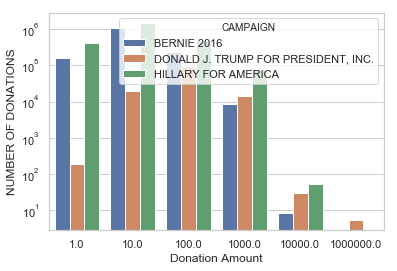

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

histogram_data=pd.read_csv('histogram_output.csv',names=['BUCKET','NUMBER OF DONATIONS','CAMPAIGN'])
#Replace the bucket number with donation amount.
histogram_data['BUCKET'] = 10**(histogram_data['BUCKET'])
print(histogram_data)

sns.set(style="whitegrid")
g = sns.barplot(x="BUCKET", y="NUMBER OF DONATIONS", hue="CAMPAIGN", data=histogram_data)
g.set_yscale('log')
g.set(xlabel='Donation Amount')
plt.show()